In [1]:
# libreries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.transforms import Compose, Resize, Grayscale, InterpolationMode
from skimage.transform import resize
import cv2, celldetection as cd
import dataset as ds
import contours as cn
import re
import io
import zipfile
from pathlib import Path
import os
import requests
import random

c:\Users\lidzi\anaconda3\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\lidzi\anaconda3\Lib\site-packages\celldetection\models\mamba.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


In [8]:

data_dir = "./data"  


In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
def plot_images(*args):
    f, ax = plt.subplots(1, len(args), figsize=(20, 20))
    for i in range(len(args)):
        img = args[i][0]

        # If tensor, convert to numpy
        if isinstance(img, torch.Tensor):
            img = img.cpu().detach().numpy()

        # If shape is (1, H, W) → squeeze to (H, W)
        if img.ndim == 3 and img.shape[0] == 1:
            img = img.squeeze(0)

        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(args[i][1])
        ax[i].axis("off")
    plt.show()


def plot_results(*args):
    for i in range(len(args)):
        plt.plot(args[i][0], label=args[i][1])

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
class ToFloat():
    def __call__(self, x):
        # Ensure the input is numpy array before casting
        if isinstance(x, np.ndarray):
            return x.astype(np.float32)
        # If it's already a tensor, check if it's an integer type and cast
        elif isinstance(x, torch.Tensor) and x.dtype in [torch.int, torch.long]:
            return x.float()
        # Otherwise, return as is
        return x

class ToTensor():
    def __call__(self, x):
        if isinstance(x, torch.Tensor):
            # Already a tensor — check it's [C, H, W]
            if x.ndim == 3 and x.shape[0] in [1, 3]:
                return x
            else:
                raise ValueError(f"[ERROR] Tensor shape not channel-first [C,H,W]: {x.shape}")
        
        elif isinstance(x, np.ndarray):
            if x.ndim == 2:
                return torch.from_numpy(x.copy()).unsqueeze(0)  # [H, W] → [1, H, W]
            elif x.ndim == 3:
                if x.shape[2] in [1, 3]:  # [H, W, C]
                    return torch.from_numpy(x.copy()).permute(2, 0, 1)  # → [C, H, W]
                elif x.shape[0] in [1, 3] and x.shape[1] == x.shape[2]:
                    # Already [C, H, W] stored as NumPy (rare)
                    return torch.from_numpy(x.copy())
                else:
                    raise ValueError(f"[ERROR] Unexpected ndarray shape: {x.shape}")
            else:
                raise ValueError(f"[ERROR] Unsupported ndarray shape: {x.shape}")
        
        else:
            raise TypeError(f"[ERROR] Unsupported input type: {type(x)}")

class Normalize():
    def __init__(self, min=None, max =None, eps=1e-8):
        self.min = min
        self.max = max
        self.eps = eps

    def __call__(self, x):
        if self.min is not None and self.max is not None:
            return (x - self.min) / (self.max - self.min + self.eps)
        else:
            # Ensure x is float before min/max/division
            x = x.float() if isinstance(x, torch.Tensor) else x.astype(np.float32)
            return (x - x.min()) / (x.max() - x.min() + self.eps)


class Instance2Semantic():
    """
    Converts instance segmentation masks into binary foreground/background masks
    """
    def __call__(self, x):
        # Ensure the output is float after binary conversion
        return (x > 0).astype(np.float32)


In [ ]:
class MakeSquare():
    def __call__(self, x, a=None, b=None, m=None):
        h, w = x.shape[:2]
        if h > w:
            dh = h - w
            m = w if m is None else m
            a = np.random.randint(0, dh + 1) if a is None else a
            b = 0
        else:
            dw = w - h
            m = h if m is None else m
            a = 0
            b = np.random.randint(0, dw + 1) if b is None else b

        x = x[a:a + m, b:b + m]
        return x, a, b, m

def image_to_square(im, label, s=448, transform=False):
    ms = MakeSquare()
    im, a, b, m = ms(im)
    label, _, _, _ = ms(label, a=a, b=b, m=m)

    image_transforms = Compose([
        ToFloat(),
        ToTensor(),
        Grayscale(1),
        Resize((s, s), interpolation=InterpolationMode.NEAREST),
        Normalize(),
    ])
    label_transforms = Compose([
        Instance2Semantic(),
        ToTensor(),
        Resize((s, s), interpolation=InterpolationMode.NEAREST),
    ])

    if transform:
        return image_transforms(im), label_transforms(label)
    return im, label


In [6]:
from pathlib import Path
import os
import skimage.io
import torch

def create_dataset(dataset_dir, sequenc="images", labels="labels"):
    """
    Load images and masks from a dataset directory.
    Returns: Tensors of shape [N, 1, H, W]
    """
    img_dir = dataset_dir / sequenc
    msk_dir = dataset_dir / labels

    # Accept both .tif and .tiff (case-insensitive)
    def is_tiff(file): return file.lower().endswith((".tif", ".tiff"))

    img_files = sorted([img_dir / f for f in os.listdir(img_dir) if is_tiff(f)])
    msk_files = sorted([msk_dir / f for f in os.listdir(msk_dir) if is_tiff(f)])

    if not img_files or not msk_files:
        raise RuntimeError(f"No .tif/.tiff files found in {img_dir} or {msk_dir}")

    images, masks = [], []

    for img_fp, msk_fp in zip(img_files, msk_files):
        img = skimage.io.imread(str(img_fp))
        msk = skimage.io.imread(str(msk_fp))

        # Apply square cropping and transforms
        im_tensor, lab_tensor = image_to_square(img, msk, transform=True)  # Each: [1, H, W]
        images.append(im_tensor)
        masks.append(lab_tensor)

    # Stack into tensors: [N, 1, H, W]
    return torch.stack(images), torch.stack(masks)


In [9]:
import imagecodecs

from pathlib import Path
import os

x_test, y_test = create_dataset(Path(f"{data_dir}/Tuning"), "images", "labels")
x_train, y_train = create_dataset(Path(f"{data_dir}/Training"), "images", "labels")
x_val = x_train[-20:]
x_train = x_train[:-20]
y_val = y_train[-20:]
y_train = y_train[:-20]

In [10]:
class UNetDatasetAlbumentations(Dataset):
    def __init__(self, image, label, patch_size=(448, 448), padding=None, transform=None, phase="train"):
        self.phase = phase
        self.transform = transform
        # Ensure patch_size is always a tuple
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        self.patch_size = patch_size
        self.padding = padding

        # ...existing code...
        self.image = image  # Expected shape: [C, H, W]
        self.label = label  # Expected shape: [1, H, W]

    def __len__(self):
        return 1  # One full image-label pair

    def __getitem__(self, index):
        x = self.image
        y = self.label

        # ✅ Assert shape is as expected
        assert tuple(x.shape[-2:]) == self.patch_size, \
            f"Expected image size {self.patch_size}, got {tuple(x.shape[-2:])}"

        # Convert to HWC for Albumentations
        x_np = x.squeeze(0).cpu().numpy() if x.shape[0] == 1 else np.transpose(x.cpu().numpy(), (1, 2, 0))  # [H, W] or [H, W, C]
        y_np = y.squeeze(0).cpu().numpy().astype(np.uint8)
        
        # Convert grayscale → RGB if needed
        if x_np.ndim == 2:
            x_np_rgb = cv2.cvtColor(x_np, cv2.COLOR_GRAY2RGB)
        elif x_np.ndim == 3 and x_np.shape[2] == 1:
            x_np_rgb = cv2.cvtColor(x_np.squeeze(-1), cv2.COLOR_GRAY2RGB)
        else:
            x_np_rgb = x_np

        if self.transform:
            augmented = self.transform(image=x_np_rgb, mask=y_np)
            x_aug = augmented["image"]  # [3, H, W]
            y_aug = augmented["mask"].unsqueeze(0).float()  # [1, H, W]
            x_aug = x_aug.mean(dim=0, keepdim=True)  # [1, H, W]
        else:
            x_aug = torch.tensor(x).float()
            y_aug = torch.tensor(y).float()

        return x_aug, y_aug



In [11]:

# === Custom Collate (if needed) ===
def custom_collate(batch):
    images, masks = zip(*batch)
    images = torch.stack(images)
    masks = torch.stack(masks)
    return images, masks

In [12]:
from torch.utils.data import DataLoader, ConcatDataset

def get_dataloader(x, y, batch_size, patch_size, padding, transform, phase):
    assert phase in ["train", "validate", "test"]
    shuffle = phase == "train"
    data = []

    for i in range(x.shape[0]):
        dataset = UNetDatasetAlbumentations(
            image=x[i],
            label=y[i],
            patch_size=patch_size,
            padding=padding,
            transform=transform,
            phase=phase
        )
        data.append(dataset)

    dataloader = DataLoader(dataset=ConcatDataset(data),
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=0,
                            collate_fn=custom_collate)
    return dataloader



In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transforms(is_train=True):
    if is_train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ISONoise(intensity=(0.1, 0.2), p=0.3),
            A.MotionBlur(blur_limit=3, p=0.2),
            A.ElasticTransform(p=0.1, alpha=40, sigma=5),
            ToTensorV2(),  # Just this — no Normalize
        ])
    else:
        return A.Compose([
            ToTensorV2(),  # no Normalize
        ])



In [14]:
train_transform = get_transforms(is_train=True)
val_transform = get_transforms(is_train=False)

train_loader = get_dataloader(
    x=x_train, y=y_train,
    batch_size=2,
    patch_size=(448, 448),
    padding=(0, 0),
    transform=train_transform,
    phase="train"
)

val_loader = get_dataloader(
    x=x_val, y=y_val,
    batch_size=1,
    patch_size=(448, 448),
    padding=(0, 0),
    transform=val_transform,
    phase="validate"
)



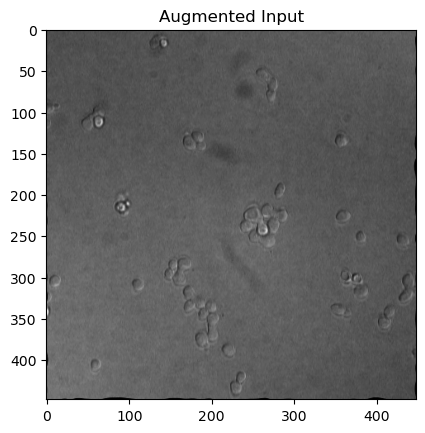

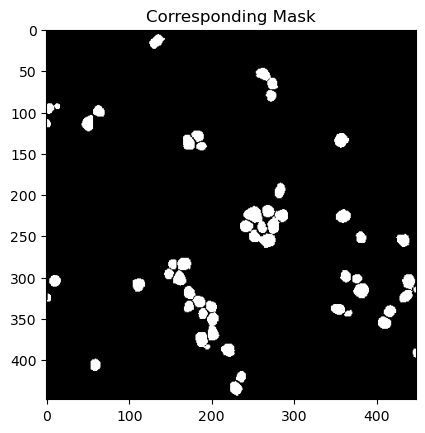

In [15]:
x_vis, y_vis = next(iter(train_loader))
plt.imshow(x_vis[0].squeeze().cpu(), cmap='gray')
plt.title("Augmented Input")
plt.show()
plt.imshow(y_vis[0].squeeze().cpu(), cmap='gray')
plt.title("Corresponding Mask")
plt.show()


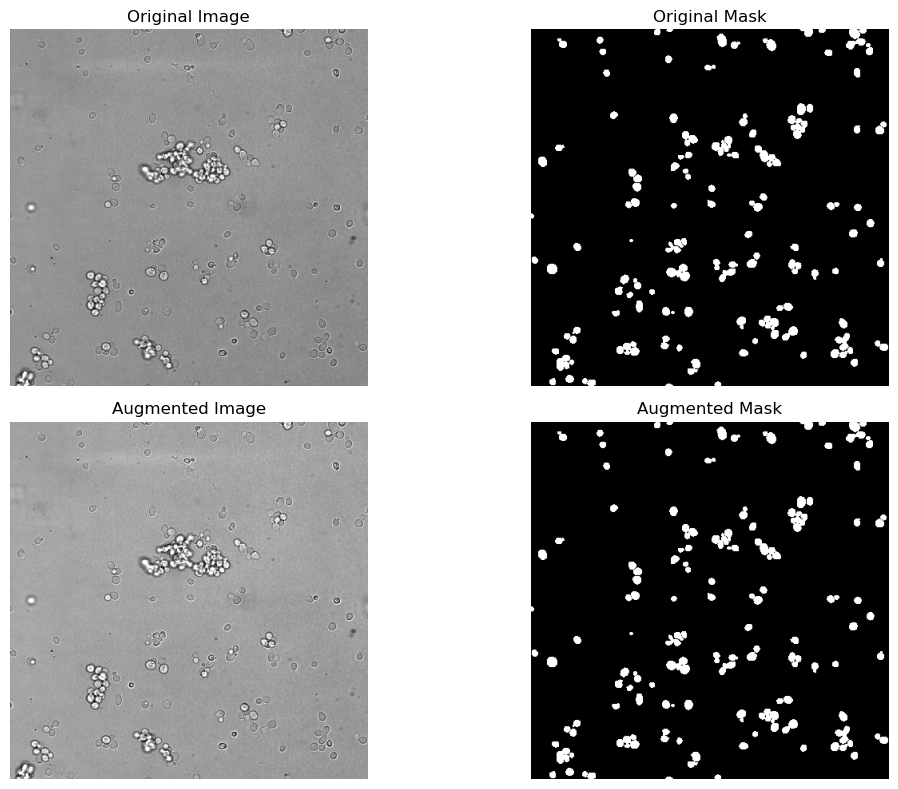

In [16]:
import cv2

# Grab one training image and label
i = 3  # index of image to visualize

# Ensure orig_image and orig_label are NumPy arrays
orig_image = x_train[i].squeeze()
orig_label = y_train[i].squeeze()
if isinstance(orig_image, torch.Tensor):
    orig_image = orig_image.cpu().numpy()
if isinstance(orig_label, torch.Tensor):
    orig_label = orig_label.cpu().numpy()

# Define transform (same as used in training)
transform = get_transforms(is_train=True)

# Handle grayscale or RGB input
if orig_image.ndim == 2:
    image_np = cv2.cvtColor(orig_image, cv2.COLOR_GRAY2RGB)
elif orig_image.ndim == 3 and orig_image.shape[0] == 1:
    image_np = cv2.cvtColor(orig_image.squeeze(0), cv2.COLOR_GRAY2RGB)
elif orig_image.ndim == 3 and orig_image.shape[2] == 1:
    image_np = cv2.cvtColor(orig_image.squeeze(-1), cv2.COLOR_GRAY2RGB)
else:
    image_np = orig_image  # Already RGB

label_np = orig_label.astype(np.uint8)

# Apply transform
aug = transform(image=image_np, mask=label_np)
aug_image = aug["image"].mean(dim=0).cpu().numpy()  # Convert [3, H, W] → [H, W] grayscale
aug_mask = aug["mask"].squeeze().cpu().numpy()

# Plot original and augmented images & masks
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(orig_image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(orig_label, cmap="gray")
plt.title("Original Mask")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(aug_image, cmap="gray")
plt.title("Augmented Image")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(aug_mask, cmap="gray")
plt.title("Augmented Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1


c:\Users\lidzi\anaconda3\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


C:\Users\lidzi\AppData\Local\Temp\ipykernel_13156\3372666057.py:37: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.where(denominator == 0, 1.0, numerator / denominator))
C:\Users\lidzi\AppData\Local\Temp\ipykernel_13156\3372666057.py:42: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.where(union == 0, 1.0, intersection / union))


Epoch 1/25 | Train Loss: 1.2734 | Val Loss: 1.2343 | Dice: 0.3520 | IoU: 0.3520
Epoch 2/25 | Train Loss: 1.1138 | Val Loss: 1.0588 | Dice: 0.4170 | IoU: 0.4081
Epoch 3/25 | Train Loss: 0.9941 | Val Loss: 0.9568 | Dice: 0.3402 | IoU: 0.3060
Epoch 4/25 | Train Loss: 0.9504 | Val Loss: 0.9284 | Dice: 0.3756 | IoU: 0.3314
Epoch 5/25 | Train Loss: 0.9270 | Val Loss: 0.8942 | Dice: 0.3931 | IoU: 0.3715
Epoch 6/25 | Train Loss: 0.9005 | Val Loss: 0.8843 | Dice: 0.4690 | IoU: 0.3901
Epoch 7/25 | Train Loss: 0.8719 | Val Loss: 0.7218 | Dice: 0.6221 | IoU: 0.5406
Epoch 8/25 | Train Loss: 0.8029 | Val Loss: 0.5348 | Dice: 0.7130 | IoU: 0.6327
Epoch 9/25 | Train Loss: 0.7715 | Val Loss: 0.6258 | Dice: 0.5524 | IoU: 0.4645
Epoch 10/25 | Train Loss: 0.7137 | Val Loss: 0.4624 | Dice: 0.6157 | IoU: 0.5371
Epoch 11/25 | Train Loss: 0.6616 | Val Loss: 0.4303 | Dice: 0.7397 | IoU: 0.6665
Epoch 12/25 | Train Loss: 0.6248 | Val Loss: 0.4248 | Dice: 0.7273 | IoU: 0.6569
Epoch 13/25 | Train Loss: 0.6097 | Va

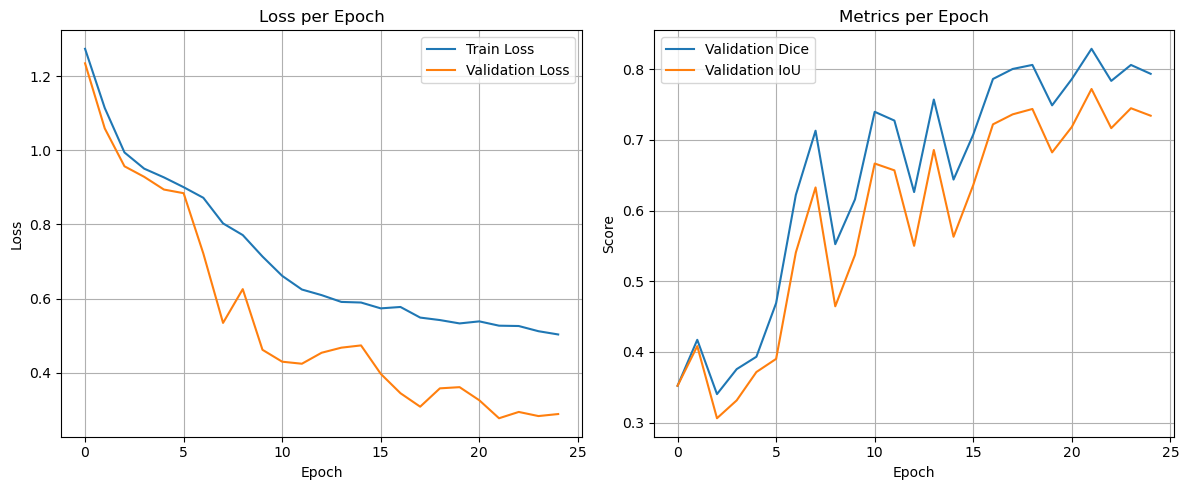

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import gc

from swin_unet_gray import SwinTransformerSys

# === Use consistent parameters ===
params = {
    'lr': 2.141193268484345e-05,
    'batch_size': 2,
    'embed_dim': 128,
    'num_heads': [4, 8, 16, 32]
}
patch_size = 448
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Instantiate model ===
model = SwinTransformerSys(
    img_size=448,          # full input image size
    in_chans=1,
    num_classes=1,
    embed_dim=128,
    depths=[2, 2, 2, 2],
    num_heads=[4, 8, 16, 32]
).to(device)


optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# === Define loss and metrics ===
def Dice(pred, gt):
    numerator = 2 * np.sum(pred * gt, axis=(1, 2))
    denominator = np.sum(pred, axis=(1, 2)) + np.sum(gt, axis=(1, 2))
    return np.mean(np.where(denominator == 0, 1.0, numerator / denominator))

def IoU(pred, gt):
    intersection = np.sum(pred * gt, axis=(1, 2))
    union = np.sum(pred, axis=(1, 2)) + np.sum(gt, axis=(1, 2)) - intersection
    return np.mean(np.where(union == 0, 1.0, intersection / union))

def combined_loss(logits, target):
    bce = nn.BCEWithLogitsLoss()(logits, target)
    pred = torch.sigmoid(logits)
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice_loss = 1 - (2. * intersection + 1e-5) / (union + 1e-5)
    return bce + dice_loss.mean()

# === Load dataloaders ===
train_transform = get_transforms(is_train=True)
val_transform = get_transforms(is_train=False)

train_loader = get_dataloader(
    x=x_train, y=y_train,
    batch_size=2,
    patch_size=(448, 448),
    padding=(0, 0),
    transform=train_transform,
    phase="train"
)

val_loader = get_dataloader(
    x=x_val, y=y_val,
    batch_size=1,
    patch_size=(448, 448),
    padding=(0, 0),
    transform=val_transform,
    phase="validate"
)

# === Training loop ===
epochs = 25
train_losses, val_losses = [], []
epoch_dices, epoch_ious = [], []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = combined_loss(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    epoch_val_loss = 0
    dice_vals, iou_vals = [], []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            loss = combined_loss(logits, y_batch)
            epoch_val_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.3).float().cpu().numpy()
            y_true = y_batch.cpu().numpy()
            dice_vals.append(Dice(preds, y_true))
            iou_vals.append(IoU(preds, y_true))

    val_losses.append(epoch_val_loss / len(val_loader))
    mean_dice = np.mean(dice_vals)
    mean_iou = np.mean(iou_vals)
    epoch_dices.append(mean_dice)
    epoch_ious.append(mean_iou)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Dice: {mean_dice:.4f} | IoU: {mean_iou:.4f}")

    torch.cuda.empty_cache()
    gc.collect()

# === Save the model ===
torch.save(model.state_dict(), "best_swin_old_architecture.pth")

# === Plot metrics ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epoch_dices, label="Validation Dice")
plt.plot(epoch_ious, label="Validation IoU")
plt.title("Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("metrics_plot.png")
plt.show()


In [ ]:
def visualize_prediction(x_batch, y_batch, pred_mask, idx=0):
    # x_batch, y_batch: tensors of shape [B, C, H, W]
    # pred_mask: predicted mask as numpy array [B, 1, H, W] or [B, H, W]
    # idx: which sample in batch to visualize

    img = x_batch[idx].cpu().numpy().squeeze()  # [H, W]
    true_mask = y_batch[idx].cpu().numpy().squeeze()  # [H, W]
    pred = pred_mask[idx]
    if pred.ndim == 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)  # [H, W]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Input Image")
    axes[0].axis('off')

    axes[1].imshow(true_mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.show()

In [47]:
val_iter = iter(val_loader)


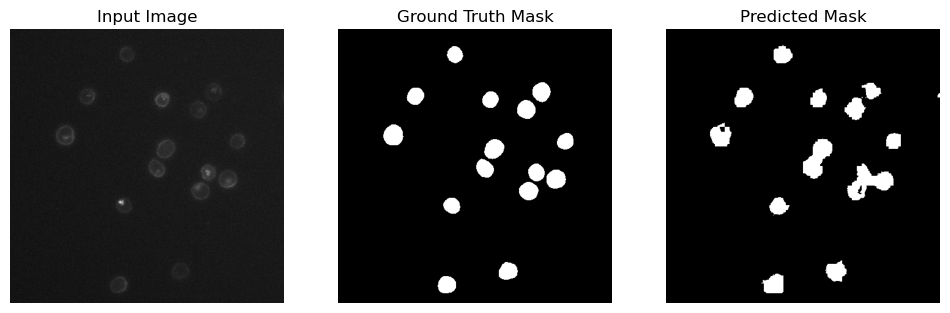

In [51]:
import random

try:
    x_batch, y_batch = next(val_iter)
except StopIteration:
    val_iter = iter(val_loader)
    x_batch, y_batch = next(val_iter)

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

with torch.no_grad():
    logits = model(x_batch)
    preds = (torch.sigmoid(logits) > 0.3).float().cpu().numpy()

idx = random.randint(0, x_batch.size(0) - 1)
visualize_prediction(x_batch, y_batch, preds, idx)


In [ ]:
from pathlib import Path
import skimage.io

def count_image_channels(image_dir):
    grayscale_count = 0
    rgb_count = 0
    other_count = 0

    image_paths = list(Path(image_dir).glob("*.tif")) + list(Path(image_dir).glob("*.tiff"))

    for path in image_paths:
        img = skimage.io.imread(str(path))
        if img.ndim == 2:
            grayscale_count += 1
        elif img.ndim == 3 and img.shape[2] == 3:
            rgb_count += 1
        else:
            other_count += 1
            print(f"⚠️  Unusual image shape: {img.shape} at {path.name}")

    total = len(image_paths)
    print(f"\n📊 Total images: {total}")
    print(f"🖤 Grayscale:     {grayscale_count}")
    print(f"🌈 RGB:           {rgb_count}")
    print(f"❓ Other/Unknown: {other_count}")

# Example usage
count_image_channels("data/Tuning/images")



📊 Total images: 58
🖤 Grayscale:     30
🌈 RGB:           28
❓ Other/Unknown: 0
